In [2]:
import gensim.downloader as api

wv = api.load("word2vec-google-news-300")

In [3]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
import pandas as pd

path = '/content/drive/MyDrive/kaggle/Fake_Real_Data.csv'

df = pd.read_csv(path)

In [5]:
df.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [6]:
wv_great = wv['great']
wv_good = wv['good']

In [7]:
wv_great.shape
wv_good.shape

(300,)

In [8]:
df.label.value_counts()

Fake    5000
Real    4900
Name: label, dtype: int64

In [9]:
df["label_num"] = df.label.map({
    "Fake":0,
    "Real":1
})

df.head()

,Text,label,label_num
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0
1,U.S. conservative leader optimistic of common ...,Real,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0
4,Democrats say Trump agrees to work on immigrat...,Real,1


In [10]:
import spacy
!python -m spacy download en_core_web_lg --quiet
nlp = spacy.load("en_core_web_lg")

def preprocess_and_vectorize(text):
  doc = nlp(text)

  filtered_tokens = []
  for token in doc:
    if token.is_punct or token.is_stop:
      continue
    filtered_tokens.append(token.lemma_)
  return wv.get_mean_vector(filtered_tokens)

2023-12-10 09:26:09.385095: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 09:26:09.385199: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 09:26:09.385256: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 09:26:11.995177: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [11]:
df['vector'] = df['Text'].apply(lambda text: preprocess_and_vectorize(text))

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values,
    df.label_num,
    test_size=0.2,
    random_state=2022,
    stratify=df.label_num
)

In [13]:
import numpy as np

print("Shape of X_train before reshaping: ", X_train.shape)
print("Shape of X_test before reshaping: ", X_test.shape)

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

print("Shape of X_train after reshaping: ", X_train_2d.shape)
print("Shape of X_test after reshaping: ", X_test_2d.shape)

Shape of X_train before reshaping:  (7920,)
Shape of X_test before reshaping:  (1980,)
Shape of X_train after reshaping:  (7920, 300)
Shape of X_test after reshaping:  (1980, 300)


In [14]:
X_train_2d[:3]

array([[-2.58219568e-03,  6.66544260e-03,  2.52646767e-03,
         3.95730063e-02, -1.41182542e-02, -7.22123589e-03,
         3.15938070e-02, -3.18326391e-02,  1.62770562e-02,
         2.15391051e-02, -2.36972049e-02, -3.72144543e-02,
        -6.70092739e-03,  1.64224133e-02, -2.48180293e-02,
         4.60469536e-02,  6.02065027e-03,  2.53213309e-02,
         4.08343738e-03, -3.32745500e-02,  6.01468608e-03,
         1.92604307e-02,  4.28487025e-02, -2.15403945e-03,
         2.04510838e-02,  3.04712215e-03, -2.73784697e-02,
        -1.53319014e-03,  6.67838380e-03, -3.27401888e-03,
        -1.53824072e-02,  9.19036320e-05, -2.74383668e-02,
        -3.54807038e-04, -1.12002371e-02, -1.66487973e-02,
         1.40579836e-02,  2.69189221e-03, -4.44610231e-03,
         3.41382883e-02,  5.02199680e-03, -1.35964267e-02,
         4.29993980e-02,  1.10096289e-02, -5.67582203e-03,
        -1.63680799e-02, -2.08231565e-02,  8.67405720e-03,
        -1.27506657e-02,  3.22506502e-02, -1.29026920e-0

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

clf = GradientBoostingClassifier()

clf.fit(X_train_2d, y_train)

y_pred = clf.predict(X_test_2d)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1000
           1       0.97      0.99      0.98       980

    accuracy                           0.98      1980
   macro avg       0.98      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980



In [16]:
test_news = [
    "China Coast Guard water cannons, rams Philippine boats on resupply mission",
    "China's Xi looks to strengthen Vietnam ties after Biden visit",
    "A man from Philippines created the solution for Global Warming"
]

test_news_vectors = [preprocess_and_vectorize(n) for n in test_news]
clf.predict(test_news_vectors)

array([0, 1, 1])

Text(95.72222222222221, 0.5, 'Truth')

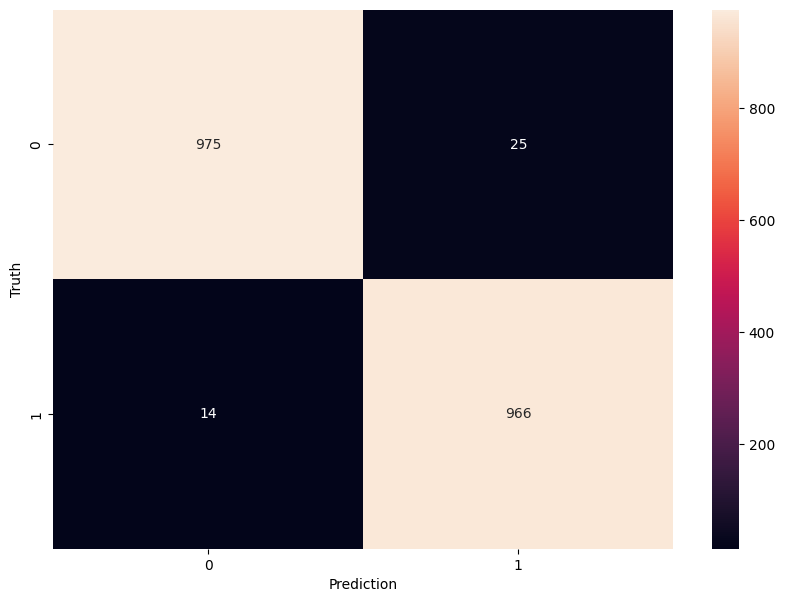

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')